# Wrangle New Jersey census tract data

In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping
import numpy as np


import warnings
warnings.simplefilter(action='ignore')

### Health Insurance Coverage Status By Sex By Age (2018 5-year estimates)

In [5]:
# read insurance coverage data in
insurance = pd.read_csv('../data/2018-5yr-new-jersey-insurance.csv', encoding='latin-1', header=1)
list(insurance.columns)

['id',
 'Geographic Area Name',
 'Estimate!!Total',
 'Margin of Error!!Total',
 'Estimate!!Total!!Male',
 'Margin of Error!!Total!!Male',
 'Estimate!!Total!!Male!!Under 6 years',
 'Margin of Error!!Total!!Male!!Under 6 years',
 'Estimate!!Total!!Male!!Under 6 years!!With health insurance coverage',
 'Margin of Error!!Total!!Male!!Under 6 years!!With health insurance coverage',
 'Estimate!!Total!!Male!!Under 6 years!!No health insurance coverage',
 'Margin of Error!!Total!!Male!!Under 6 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!6 to 18 years',
 'Margin of Error!!Total!!Male!!6 to 18 years',
 'Estimate!!Total!!Male!!6 to 18 years!!With health insurance coverage',
 'Margin of Error!!Total!!Male!!6 to 18 years!!With health insurance coverage',
 'Estimate!!Total!!Male!!6 to 18 years!!No health insurance coverage',
 'Margin of Error!!Total!!Male!!6 to 18 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!19 to 25 years',
 'Margin of Error!!Total!!Male!!19 to 

I only want to keep the identifying columns, the total estimate, and I need a column for total uninsured. Then I can calculate a percent uninsured.

In [6]:
# first filter to keep columns that contain estimate, to eliminate the margin of error columns
colNames = insurance.columns.str.contains('id|Geographic Area Name|Estimate', case=False)
insurance_filter = insurance.iloc[:, colNames]
list(insurance_filter.columns)

['id',
 'Geographic Area Name',
 'Estimate!!Total',
 'Estimate!!Total!!Male',
 'Estimate!!Total!!Male!!Under 6 years',
 'Estimate!!Total!!Male!!Under 6 years!!With health insurance coverage',
 'Estimate!!Total!!Male!!Under 6 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!6 to 18 years',
 'Estimate!!Total!!Male!!6 to 18 years!!With health insurance coverage',
 'Estimate!!Total!!Male!!6 to 18 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!19 to 25 years',
 'Estimate!!Total!!Male!!19 to 25 years!!With health insurance coverage',
 'Estimate!!Total!!Male!!19 to 25 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!26 to 34 years',
 'Estimate!!Total!!Male!!26 to 34 years!!With health insurance coverage',
 'Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!35 to 44 years',
 'Estimate!!Total!!Male!!35 to 44 years!!With health insurance coverage',
 'Estimate!!Total!!Male!!35 to 44 years!!No health insurance

In [7]:
# create list of all columns that describe a group with no health coverage
colNames = insurance_filter.columns.str.contains('No', case=False)
no_insurance = insurance_filter.iloc[:, colNames]
col_list = list(no_insurance.columns)
col_list

['Estimate!!Total!!Male!!Under 6 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!6 to 18 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!19 to 25 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!45 to 54 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!55 to 64 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!65 to 74 years!!No health insurance coverage',
 'Estimate!!Total!!Male!!75 years and over!!No health insurance coverage',
 'Estimate!!Total!!Female!!Under 6 years!!No health insurance coverage',
 'Estimate!!Total!!Female!!6 to 18 years!!No health insurance coverage',
 'Estimate!!Total!!Female!!19 to 25 years!!No health insurance coverage',
 'Estimate!!Total!!Female!!26 to 34 years!!No health insurance coverage',
 'Estimate!!Total!!Female!!35 to 44 years!!No health insu

In [8]:
# create new field that is the sum of all columns describing groups with no health coverage
insurance_filter['totalUninsured'] = insurance_filter[col_list].sum(axis=1)
insurance_filter.head()

,id,Geographic Area Name,Estimate!!Total,Estimate!!Total!!Male,Estimate!!Total!!Male!!Under 6 years,Estimate!!Total!!Male!!Under 6 years!!With health insurance coverage,Estimate!!Total!!Male!!Under 6 years!!No health insurance coverage,Estimate!!Total!!Male!!6 to 18 years,Estimate!!Total!!Male!!6 to 18 years!!With health insurance coverage,Estimate!!Total!!Male!!6 to 18 years!!No health insurance coverage,...,Estimate!!Total!!Female!!55 to 64 years,Estimate!!Total!!Female!!55 to 64 years!!With health insurance coverage,Estimate!!Total!!Female!!55 to 64 years!!No health insurance coverage,Estimate!!Total!!Female!!65 to 74 years,Estimate!!Total!!Female!!65 to 74 years!!With health insurance coverage,Estimate!!Total!!Female!!65 to 74 years!!No health insurance coverage,Estimate!!Total!!Female!!75 years and over,Estimate!!Total!!Female!!75 years and over!!With health insurance coverage,Estimate!!Total!!Female!!75 years and over!!No health insurance coverage,totalUninsured
0,1400000US34013019900,"Census Tract 199, Essex County, New Jersey",2604,1237,72,72,0,269,269,0,...,176,167,9,81,81,0,68,68,0,50
1,1400000US34013020700,"Census Tract 207, Essex County, New Jersey",4254,2203,111,111,0,544,535,9,...,314,284,30,224,214,10,154,154,0,132
2,1400000US34013012200,"Census Tract 122, Essex County, New Jersey",5122,2559,114,114,0,618,427,191,...,280,280,0,207,207,0,51,51,0,973
3,1400000US34013012400,"Census Tract 124, Essex County, New Jersey",4524,2185,153,153,0,469,433,36,...,537,413,124,309,303,6,141,141,0,713
4,1400000US34013013000,"Census Tract 130, Essex County, New Jersey",1935,1019,53,53,0,108,108,0,...,157,157,0,46,46,0,105,83,22,182


In [9]:
# create new insurance dataframe by filtering only the columns I need
insurance_coverage = insurance_filter.filter(['id', 'Geographic Area Name', 'Estimate!!Total', 'totalUninsured'])

# rename columns
insurance_coverage = insurance_coverage.rename(columns={'Geographic Area Name': 'name',
                                                       'Estimate!!Total': 'totalPop',})
insurance_coverage.head()

,id,name,totalPop,totalUninsured
0,1400000US34013019900,"Census Tract 199, Essex County, New Jersey",2604,50
1,1400000US34013020700,"Census Tract 207, Essex County, New Jersey",4254,132
2,1400000US34013012200,"Census Tract 122, Essex County, New Jersey",5122,973
3,1400000US34013012400,"Census Tract 124, Essex County, New Jersey",4524,713
4,1400000US34013013000,"Census Tract 130, Essex County, New Jersey",1935,182


In [10]:
# add new field for percent uninsured
insurance_coverage['percentUninsured'] = (insurance_coverage['totalUninsured']/insurance_coverage['totalPop'])*100
insurance_coverage.head()

,id,name,totalPop,totalUninsured,percentUninsured
0,1400000US34013019900,"Census Tract 199, Essex County, New Jersey",2604,50,1.920123
1,1400000US34013020700,"Census Tract 207, Essex County, New Jersey",4254,132,3.102962
2,1400000US34013012200,"Census Tract 122, Essex County, New Jersey",5122,973,18.996486
3,1400000US34013012400,"Census Tract 124, Essex County, New Jersey",4524,713,15.760389
4,1400000US34013013000,"Census Tract 130, Essex County, New Jersey",1935,182,9.405685


In [11]:
# view insurance coverage statistics
insurance_coverage.describe()

,totalPop,totalUninsured,percentUninsured
count,2010.000000,2010.000000,1995.000000
mean,4366.586567,369.674129,8.626819
std,1871.392181,366.057654,7.370553
min,0.000000,0.000000,0.000000
25%,3055.000000,126.000000,3.325461
50%,4194.000000,248.000000,6.406769
75%,5556.750000,496.000000,11.472247
max,16536.000000,3010.000000,46.652201


### Poverty Status in the past 12 months (2018 5-year estimates)

In [12]:
# read poverty data in
poverty = pd.read_csv('../data/2018-5yr-new-jersey-poverty.csv', encoding='latin-1', header=1)
list(poverty.columns)

['id',
 'Geographic Area Name',
 'Estimate!!Total!!Population for whom poverty status is determined',
 'Margin of Error!!Total MOE!!Population for whom poverty status is determined',
 'Estimate!!Below poverty level!!Population for whom poverty status is determined',
 'Margin of Error!!Below poverty level MOE!!Population for whom poverty status is determined',
 'Estimate!!Percent below poverty level!!Population for whom poverty status is determined',
 'Margin of Error!!Percent below poverty level MOE!!Population for whom poverty status is determined',
 'Estimate!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years',
 'Margin of Error!!Total MOE!!Population for whom poverty status is determined!!AGE!!Under 18 years',
 'Estimate!!Below poverty level!!Population for whom poverty status is determined!!AGE!!Under 18 years',
 'Margin of Error!!Below poverty level MOE!!Population for whom poverty status is determined!!AGE!!Under 18 years',
 'Estimate!!Percent below pov

I just want to keep the identifying fields, and there is already a column for the percent below poverty level so I will not need to calculate that field from population totals.

In [45]:
# create poverty dataframe by filtering the columns I need
# for this one I can just keep the id field which will be used to join later, and the percent below poverty level
poverty_level = poverty.filter(['id', 'Estimate!!Percent below poverty level!!Population for whom poverty status is determined'])

# rename columns
poverty_level = poverty_level.rename(columns={'Geographic Area Name': 'name',
                                                        'Estimate!!Percent below poverty level!!Population for whom poverty status is determined': 'percentBelowPoverty'})

# some rows had a '-' for a null value
# replace these with nans
poverty_level = poverty_level.replace(r'-', np.nan)

# cast column to float
poverty_level['percentBelowPoverty'] = poverty_level['percentBelowPoverty'].astype(float)

### Income in the past 12 months (in 2018 inflation-adjusted dollars), 2018 5-year estimates

In [46]:
# read income data in
income = pd.read_csv('../data/2018-5yr-new-jersey-income.csv', encoding='latin-1', header=1)
list(income.columns)

['id',
 'Geographic Area Name',
 'Estimate!!Households!!Total',
 'Margin of Error!!Households MOE!!Total',
 'Estimate!!Families!!Total',
 'Margin of Error!!Families MOE!!Total',
 'Estimate!!Married-couple families!!Total',
 'Margin of Error!!Married-couple families MOE!!Total',
 'Estimate!!Nonfamily households!!Total',
 'Margin of Error!!Nonfamily households MOE!!Total',
 'Estimate!!Households!!Total!!Less than $10,000',
 'Margin of Error!!Households MOE!!Total!!Less than $10,000',
 'Estimate!!Families!!Total!!Less than $10,000',
 'Margin of Error!!Families MOE!!Total!!Less than $10,000',
 'Estimate!!Married-couple families!!Total!!Less than $10,000',
 'Margin of Error!!Married-couple families MOE!!Total!!Less than $10,000',
 'Estimate!!Nonfamily households!!Total!!Less than $10,000',
 'Margin of Error!!Nonfamily households MOE!!Total!!Less than $10,000',
 'Estimate!!Households!!Total!!$10,000 to $14,999',
 'Margin of Error!!Households MOE!!Total!!$10,000 to $14,999',
 'Estimate!!Famil

I only want to keep the mean and median income for all households, as well as the id field to be used in merging later.

In [47]:
# create new income dataframe by filtering the columns I need
income = income.filter(['id', 'Estimate!!Households!!Mean income (dollars)', 'Estimate!!Families!!Median income (dollars)'], axis =1)

# rename columns
income = income.rename(columns={'Estimate!!Households!!Mean income (dollars)': 'meanIncome',
                                         'Estimate!!Families!!Median income (dollars)': 'medianIncome'})

income.head()

,id,meanIncome,medianIncome
0,1400000US34001000100,39539,35859
1,1400000US34001000200,73164,71341
2,1400000US34001000300,53073,34235
3,1400000US34001000400,67293,33897
4,1400000US34001000500,48527,38355


### Merging the wrangled census datasets together

In [48]:
census_data1 = pd.merge(insurance_coverage, poverty_level, on='id', how='left')
census_data1.head()

,id,name,totalPop,totalUninsured,percentUninsured,percentBelowPoverty
0,1400000US34013019900,"Census Tract 199, Essex County, New Jersey",2604,50,1.920123,3.5
1,1400000US34013020700,"Census Tract 207, Essex County, New Jersey",4254,132,3.102962,2.9
2,1400000US34013012200,"Census Tract 122, Essex County, New Jersey",5122,973,18.996486,22.1
3,1400000US34013012400,"Census Tract 124, Essex County, New Jersey",4524,713,15.760389,20.6
4,1400000US34013013000,"Census Tract 130, Essex County, New Jersey",1935,182,9.405685,8.9


In [49]:
census_data = pd.merge(census_data1, income, on='id', how='left')
census_data.head()

,id,name,totalPop,totalUninsured,percentUninsured,percentBelowPoverty,meanIncome,medianIncome
0,1400000US34013019900,"Census Tract 199, Essex County, New Jersey",2604,50,1.920123,3.5,250408,235000
1,1400000US34013020700,"Census Tract 207, Essex County, New Jersey",4254,132,3.102962,2.9,157927,154375
2,1400000US34013012200,"Census Tract 122, Essex County, New Jersey",5122,973,18.996486,22.1,56009,60795
3,1400000US34013012400,"Census Tract 124, Essex County, New Jersey",4524,713,15.760389,20.6,45146,47155
4,1400000US34013013000,"Census Tract 130, Essex County, New Jersey",1935,182,9.405685,8.9,54584,71429


In [50]:
# split name column into separate columns for tract, county, and state
census_data['censusTract'], census_data['county'], census_data['state'] = census_data['name'].str.split(', ', 2).str

# grab last eleven digits from the id field to create a GEOID field for joining to shapefile
census_data['GEOID'] = census_data['id'].str[-11:]

census_data.head()

,id,name,totalPop,totalUninsured,percentUninsured,percentBelowPoverty,meanIncome,medianIncome,censusTract,county,state,GEOID
0,1400000US34013019900,"Census Tract 199, Essex County, New Jersey",2604,50,1.920123,3.5,250408,235000,Census Tract 199,Essex County,New Jersey,34013019900
1,1400000US34013020700,"Census Tract 207, Essex County, New Jersey",4254,132,3.102962,2.9,157927,154375,Census Tract 207,Essex County,New Jersey,34013020700
2,1400000US34013012200,"Census Tract 122, Essex County, New Jersey",5122,973,18.996486,22.1,56009,60795,Census Tract 122,Essex County,New Jersey,34013012200
3,1400000US34013012400,"Census Tract 124, Essex County, New Jersey",4524,713,15.760389,20.6,45146,47155,Census Tract 124,Essex County,New Jersey,34013012400
4,1400000US34013013000,"Census Tract 130, Essex County, New Jersey",1935,182,9.405685,8.9,54584,71429,Census Tract 130,Essex County,New Jersey,34013013000


### Join census data to census tract shapefile

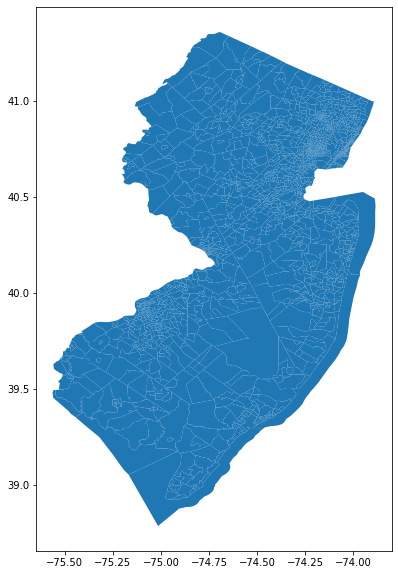

In [51]:
# read shapefile in
tracts = gpd.read_file('../data/new-jersey-tracts/tl_2019_34_tract.shp')
tracts.plot(figsize=(20,10));

In [52]:
# inspect tracts data
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,34,031,256804,34031256804,2568.04,Census Tract 2568.04,G5020,S,29792621,809082,+41.0787934,-074.3779531,"POLYGON ((-74.41591 41.08861, -74.41484 41.089..."
1,34,031,246300,34031246300,2463,Census Tract 2463,G5020,S,10100083,480508,+40.9104210,-074.2642143,"POLYGON ((-74.28932 40.92851, -74.28932 40.928..."
2,34,031,181200,34031181200,1812,Census Tract 1812,G5020,S,401624,0,+40.9242986,-074.1499553,"POLYGON ((-74.15537 40.92394, -74.15535 40.924..."
3,34,031,256803,34031256803,2568.03,Census Tract 2568.03,G5020,S,14231776,740595,+41.1221009,-074.3805752,"POLYGON ((-74.41296 41.11469, -74.41051 41.117..."
4,34,031,246003,34031246003,2460.03,Census Tract 2460.03,G5020,S,6580967,1795588,+40.9770103,-074.2610348,"POLYGON ((-74.28242 40.97003, -74.28241 40.970..."


In [53]:
# filter to drop unneccessary columns
tracts = tracts.filter(['GEOID', 'NAME', 'NAMELSAD', 'ALAND', 'geometry'], axis=1)
tracts.head()

,GEOID,NAME,NAMELSAD,ALAND,geometry
0,34031256804,2568.04,Census Tract 2568.04,29792621,"POLYGON ((-74.41591 41.08861, -74.41484 41.089..."
1,34031246300,2463,Census Tract 2463,10100083,"POLYGON ((-74.28932 40.92851, -74.28932 40.928..."
2,34031181200,1812,Census Tract 1812,401624,"POLYGON ((-74.15537 40.92394, -74.15535 40.924..."
3,34031256803,2568.03,Census Tract 2568.03,14231776,"POLYGON ((-74.41296 41.11469, -74.41051 41.117..."
4,34031246003,2460.03,Census Tract 2460.03,6580967,"POLYGON ((-74.28242 40.97003, -74.28241 40.970..."


In [54]:
# join census data to shapefile
census_tracts = pd.merge(tracts, census_data, on='GEOID', how='left')
census_tracts.head()

,GEOID,NAME,NAMELSAD,ALAND,geometry,id,name,totalPop,totalUninsured,percentUninsured,percentBelowPoverty,meanIncome,medianIncome,censusTract,county,state
0,34031256804,2568.04,Census Tract 2568.04,29792621,"POLYGON ((-74.41591 41.08861, -74.41484 41.089...",1400000US34031256804,"Census Tract 2568.04, Passaic County, New Jersey",6636,275,4.144063,2.8,137301,133125,Census Tract 2568.04,Passaic County,New Jersey
1,34031246300,2463,Census Tract 2463,10100083,"POLYGON ((-74.28932 40.92851, -74.28932 40.928...",1400000US34031246300,"Census Tract 2463, Passaic County, New Jersey",4946,626,12.656692,13.6,107248,78750,Census Tract 2463,Passaic County,New Jersey
2,34031181200,1812,Census Tract 1812,401624,"POLYGON ((-74.15537 40.92394, -74.15535 40.924...",1400000US34031181200,"Census Tract 1812, Passaic County, New Jersey",4817,714,14.822504,20.6,55115,50125,Census Tract 1812,Passaic County,New Jersey
3,34031256803,2568.03,Census Tract 2568.03,14231776,"POLYGON ((-74.41296 41.11469, -74.41051 41.117...",1400000US34031256803,"Census Tract 2568.03, Passaic County, New Jersey",5060,329,6.501976,4.5,80115,94219,Census Tract 2568.03,Passaic County,New Jersey
4,34031246003,2460.03,Census Tract 2460.03,6580967,"POLYGON ((-74.28242 40.97003, -74.28241 40.970...",1400000US34031246003,"Census Tract 2460.03, Passaic County, New Jersey",5410,93,1.719039,1.1,157672,142895,Census Tract 2460.03,Passaic County,New Jersey


In [55]:
# drop redundant columns
census_tracts = census_tracts.drop(['NAMELSAD', 'id', 'NAME', 'name'], axis=1)

# create a column with land area in square miles, converted from square meters
census_tracts['ALANDsquareMiles'] = census_tracts['ALAND'] / 2589988.110336

# create population density column
census_tracts['popDensity'] = census_tracts['totalPop']/census_tracts['ALANDsquareMiles']

census_tracts.head()

,GEOID,ALAND,geometry,totalPop,totalUninsured,percentUninsured,percentBelowPoverty,meanIncome,medianIncome,censusTract,county,state,ALANDsquareMiles,popDensity
0,34031256804,29792621,"POLYGON ((-74.41591 41.08861, -74.41484 41.089...",6636,275,4.144063,2.8,137301,133125,Census Tract 2568.04,Passaic County,New Jersey,11.502995,576.893221
1,34031246300,10100083,"POLYGON ((-74.28932 40.92851, -74.28932 40.928...",4946,626,12.656692,13.6,107248,78750,Census Tract 2463,Passaic County,New Jersey,3.899664,1268.314448
2,34031181200,401624,"POLYGON ((-74.15537 40.92394, -74.15535 40.924...",4817,714,14.822504,20.6,55115,50125,Census Tract 1812,Passaic County,New Jersey,0.155068,31063.812739
3,34031256803,14231776,"POLYGON ((-74.41296 41.11469, -74.41051 41.117...",5060,329,6.501976,4.5,80115,94219,Census Tract 2568.03,Passaic County,New Jersey,5.494919,920.850626
4,34031246003,6580967,"POLYGON ((-74.28242 40.97003, -74.28241 40.970...",5410,93,1.719039,1.1,157672,142895,Census Tract 2460.03,Passaic County,New Jersey,2.540926,2129.145409


In [58]:
# write joined census data to geojson
census_tracts.to_file("../data/new-jersey-tracts.geojson", driver='GeoJSON')

### Start plotting census data overlaid with TRI facilities and Superfund sites

In [60]:
# read in tri facilities
tri = gpd.read_file('../data/new-jersey-tri.geojson')
superfund = gpd.read_file('../data/new-jersey-superfund.geojson')

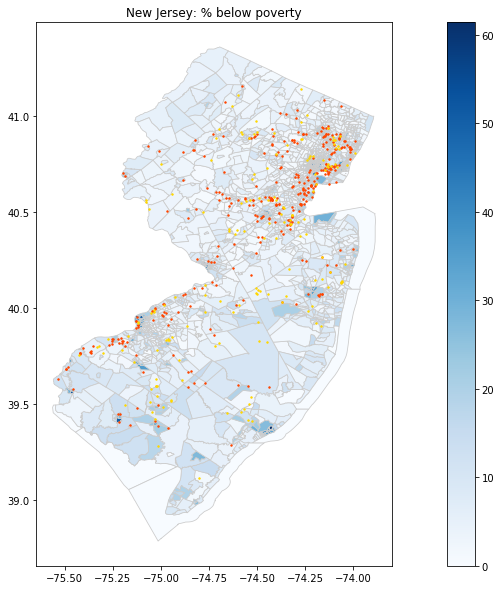

In [65]:
variable = 'percentBelowPoverty'

vmin, vmax = census_tracts['percentBelowPoverty'].min(), census_tracts['percentBelowPoverty'].max()

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

census_tracts.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8');
tri.plot(ax=ax, color='orangered', zorder=1, markersize=2);
superfund.plot(ax=ax, color='gold', zorder=1, markersize=2);

ax.set(
#     xlim=(-2500000,2200000), ylim=(-1800000,1500000), 
    title='New Jersey: % below poverty');

# create legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to map
cbar = fig.colorbar(sm)

print;

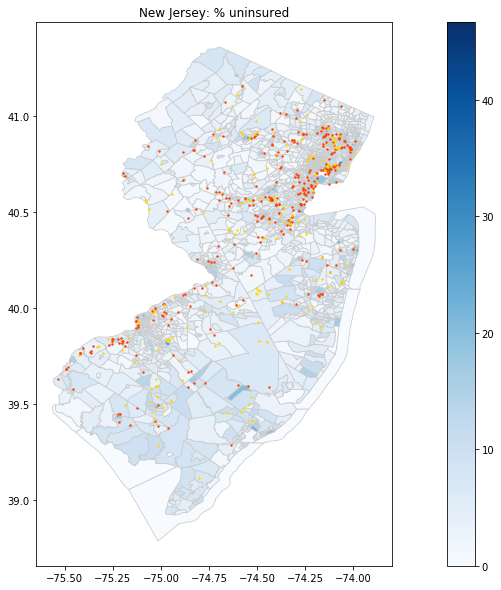

In [64]:
variable = 'percentUninsured'

vmin, vmax = census_tracts['percentUninsured'].min(), census_tracts['percentUninsured'].max()


#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

census_tracts.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
tri.plot(ax=ax, color='orangered', zorder=1, markersize=2);
superfund.plot(ax=ax, color='gold', zorder=1, markersize=2);

ax.set(
#     xlim=(-2500000,2200000), ylim=(-1800000,1500000), 
    title='New Jersey: % uninsured');

# create legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to map
cbar = fig.colorbar(sm)

print;